In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from openpyxl.drawing.image import Image

In [2]:
import sys
sys.path.append("C:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\OCP")
from Defs import merge_SalesUnits
from Defs import merge_Mapping
from Defs import Period
from Defs import new_list
from Defs import export_from_RISKCUSTOM
from Defs import add_in_currency_column

Cash:

In [4]:
query = """
SELECT "holding", SUM("balanceUsd") AS "cash", "reportDate"
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "accountStatus" = 'active' AND "bankCountryCode" = 'RU' 
AND "reportDate" >= trunc(sysdate - interval '3' month)
GROUP BY "holding", "reportDate"
ORDER BY "reportDate"
"""

data_cash = export_from_RISKCUSTOM(query)
data_cash['merge_col'] = data_cash[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_cash = data_cash.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_cash.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,cash,reportDate,merge_col
120,EUROCHEM,5.662499e+07,2024-04-05,EUROCHEM_2024-04-05 00:00:00
121,SUEK,4.136557e+07,2024-04-05,SUEK_2024-04-05 00:00:00
122,EUROCHEM,2.933775e+07,2024-04-08,EUROCHEM_2024-04-08 00:00:00
123,SUEK,4.135738e+07,2024-04-08,SUEK_2024-04-08 00:00:00
124,EUROCHEM,2.835688e+07,2024-04-09,EUROCHEM_2024-04-09 00:00:00
125,SUEK,5.545406e+07,2024-04-09,SUEK_2024-04-09 00:00:00


In [5]:
query = """
SELECT "companyCode" AS "holding", SUM("bookValuePositionCurrency") AS "pre_overdraft", "reportDate"
FROM "RISKACCESS"."sapPositionArrears"
WHERE "productType" = 130 AND "companyCode" IN ('1100', 'E200') 
AND "reportDate" >= trunc(sysdate - interval '3' month) AND "reportDate" <= (SELECT MAX("reportDate") FROM "RISKACCESS"."bankAccountsBalanceDaily")
GROUP BY "companyCode", "reportDate"
ORDER BY "reportDate"
"""

data_overdraft = export_from_RISKCUSTOM(query) # выгрузка запроса
data_overdraft.holding = data_overdraft.holding.replace({'1100': 'SUEK', 'E200':'EUROCHEM'}) # Переименовывание holding
data_overdraft['merge_col'] = data_overdraft[['holding', 'reportDate']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
data_overdraft = data_overdraft.sort_values(['reportDate', 'holding']).reset_index(drop=True)
data_overdraft.tail(6)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,holding,pre_overdraft,reportDate,merge_col
68,EUROCHEM,4.488904e+09,2024-04-03,EUROCHEM_2024-04-03 00:00:00
69,SUEK,1.010496e+10,2024-04-03,SUEK_2024-04-03 00:00:00
70,EUROCHEM,6.248775e+09,2024-04-04,EUROCHEM_2024-04-04 00:00:00
71,EUROCHEM,2.644103e+09,2024-04-05,EUROCHEM_2024-04-05 00:00:00
72,EUROCHEM,1.840786e+09,2024-04-09,EUROCHEM_2024-04-09 00:00:00
73,SUEK,1.305175e+09,2024-04-09,SUEK_2024-04-09 00:00:00


In [7]:
data_total = data_cash.merge(data_overdraft, how='outer', left_on='merge_col', right_on='merge_col')
data_total = data_total.loc[~data_total.cash.isna(), ['reportDate_x', 'holding_x', 'cash', 'pre_overdraft']].rename(columns={'reportDate_x':'reportDate', 'holding_x':'holding'}).reset_index(drop=True)
data_total.pre_overdraft = data_total.pre_overdraft.fillna(0) # Заполнение пустых значений pre_overdraft нулями
limit_df = pd.DataFrame({'holding': ['SUEK', 'EUROCHEM'], 'limit': [15000000000, 8000000000]}) # Добавление значения limit для каждого holding
data_total = data_total.merge(limit_df, how='left')
data_total['overdraft'] = data_total.limit - data_total.pre_overdraft # Вычисление overdraft

data_total['CCY'] = 'RUB'
data_total = add_in_currency_column(df=data_total, col_with_CCY='CCY', col_with_VAL='overdraft', CCY_to='USD', date_is_column=True, DATE = 'reportDate')
data_total = data_total.rename(columns={'overdraft_in_USD':'available_ovedraft'})

data_total['total'] = data_total.cash + data_total.available_ovedraft # расчет total
const_df = pd.DataFrame({'holding':['EUROCHEM', 'SUEK'], 'early_trigger': [164, 251], 'threshold': [93, 183]})
data_total = data_total.merge(const_df, how='left')
data_total[['cash', 'available_ovedraft', 'total']] = data_total[['cash', 'available_ovedraft', 'total']].astype(int).apply(lambda z: z/10**6)
data_total['day_of_week'] = data_total.reportDate.dt.day_of_week
data_total.head(2)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:79: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:146: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[f'Coef_to_{CCY_to}'] = df.date_CCY_from.replace(coef_dict)


,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,day_of_week
0,2024-01-11,EUROCHEM,14.855591,4.123961e+09,8000000000,3.876039e+09,RUB,0.011273,43.695689,58.551281,164,93,3
1,2024-01-12,EUROCHEM,14.337518,3.173628e+09,8000000000,4.826372e+09,RUB,0.011314,54.604996,68.942515,164,93,4


In [38]:
data_cash.shape, data_overdraft.shape, data_total.shape

((117, 4), (74, 4), (117, 12))

Графики:

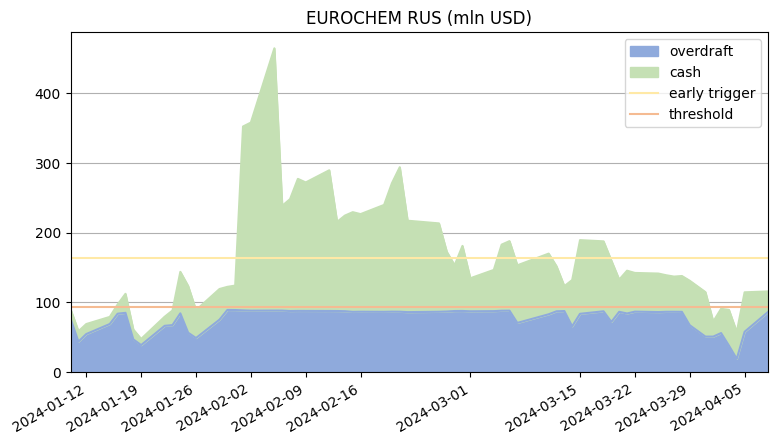

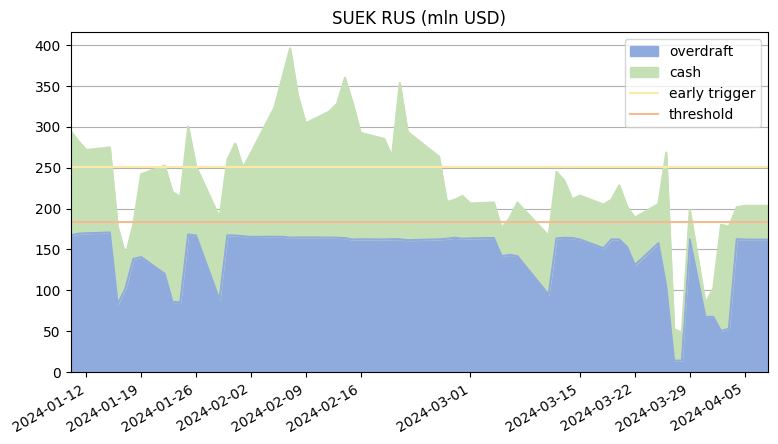

In [32]:
for i in ['EUROCHEM', 'SUEK']:
    data_plot = data_total.query("holding==@i")
    xticks = data_plot.loc[data_plot.day_of_week.isin([4]), 'reportDate'].sort_values().tolist() # Каждая n-ый день недели в качестве делелния на оси X
    # xticks = data_plot.reportDate.tolist()[::4] # Каждая n-я дата в качестве делелния на оси X
    title = i + ' RUS (mln USD)'
    ax = data_plot.plot(x='reportDate', y=['available_ovedraft', 'cash'], kind='area', stacked=True, figsize=[9, 5], title=title, color=['#8faadc', '#c5e0b4'], xticks=xticks)
    ax.axhline(y=data_plot.early_trigger.tolist()[0], color='#ffe9a6', label='early_trigger')
    ax.axhline(y=data_plot.threshold.tolist()[0], color='#f5bb92', label='threshold')
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles = handles[0:], labels=['overdraft', 'cash','early trigger', 'threshold'])
    start, end = data_plot.reportDate.min(), data_plot.reportDate.max()
    ax.set_xlim([start, end])
    ax.set_axisbelow ( True )
    ax.grid(axis='y')
    ax.set(xlabel=None)
    plt.savefig(f'{i}.png')


Запись в файл:

In [45]:
TD = data_total.reportDate.max()
TD_str = str(TD)[:10]
Output_file_SUEK = TD_str + '_Oper_liquidity_SUEK.xlsx'
Output_file_ECH = TD_str + '_Oper_liquidity_EUROCHEM.xlsx'

for i in ['EUROCHEM', 'SUEK']:
    data_print = data_total.query("holding==@i")[['reportDate', 'cash', 'available_ovedraft', 'total', 'early_trigger', 'threshold']]
    Output_file = TD_str + '_Oper_liquidity_' + i + '.xlsx'
    data_print.to_excel(Output_file, index=False)
    # Create a new or open existing Excel file with openpyxl
    wb = openpyxl.load_workbook(Output_file)  # Open existing or create new
    ws = wb.active
    # Error handling: Check if image file exists
    try:
      img = Image(f'{i}.png')
    except FileNotFoundError:
      print("Error: Image file 'EUROCHEM.png' not found. Skipping image insertion.")
      img = None  # Set img to None to avoid potential errors
    # Insert image if it exists
    if img:
      img.anchor = 'H37'  # Adjust cell reference as needed
      ws.add_image(img)
    # Save the Excel file (overwrite if existing)
    wb.save(Output_file)

In [138]:
data_total.head(2)

,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,concat_col,available_ovedraft,total,early_trigger,threshold,day_of_week
0,2024-01-09,EUROCHEM,19.379972,2.564856e+09,8000000000,5.435144e+09,RUB,0.011146,60.577879,79.957852,164,93,1
1,2024-01-10,EUROCHEM,13.560661,1.166237e+09,8000000000,6.833763e+09,RUB,0.011158,76.253162,89.813823,164,93,2


Quality_ckeck.Missing_records

In [11]:
query = """
SELECT *
FROM "RISKACCESS"."bankAccountsBalanceDaily"
WHERE "reportDate" >= trunc(sysdate - interval '30' day)
ORDER BY "reportDate"
"""

data_QC_cash = export_from_RISKCUSTOM(query)

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


In [12]:
data_QC_cash['missing_record'] = data_QC_cash[['buCode', 'bankId', 'accountCurrency', 'accountNumber']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

last_date = data_QC_cash.reportDate.unique()[-1]
pre_last_date = data_QC_cash.reportDate.unique()[-2]
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate == pre_last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

missing_records = [i for i in data_QC_cash_pre_last_date if i not in data_QC_cash_last_date]

data_missing_records = data_QC_cash[(data_QC_cash.missing_record.isin(missing_records)) & (data_QC_cash.reportDate == pre_last_date)]

Quality_ckeck.New_records

In [13]:
data_QC_cash_pre_last_date = data_QC_cash.loc[data_QC_cash.reportDate != last_date, 'missing_record'].tolist()
data_QC_cash_last_date = data_QC_cash.loc[data_QC_cash.reportDate == last_date, 'missing_record'].tolist()

new_records = [i for i in data_QC_cash_last_date if i not in data_QC_cash_pre_last_date]

data_new_records = data_QC_cash[(data_QC_cash.missing_record.isin(new_records)) & (data_QC_cash.reportDate == last_date)]

Quality_ckeck.Mapping

In [14]:
data_QC_cash['Map_holding'] = merge_SalesUnits(data_QC_cash, col='buCode', merge_col='holding')
data_QC_cash['Map_holding_2'] = merge_SalesUnits(data_QC_cash, col='buCode', id_col='oebs12ShortCode', merge_col='holding')
data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding_2'] = data_QC_cash.loc[data_QC_cash.Map_holding_2 == 'External' ,'Map_holding']
data_map_holding = data_QC_cash.loc[(data_QC_cash.Map_holding_2 != data_QC_cash.holding) & (data_QC_cash.reportDate == data_QC_cash.reportDate.max()), ['buCode', 'holding', 'Map_holding_2']].drop_duplicates()
data_map_holding

C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)
C:\Users\KlimovaAnnaA\Documents\MyFiles\Projects\OCP\Defs.py:78: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_export = pd.read_sql(query, con=connection)


,buCode,holding,Map_holding_2
65039,RUBGG,EUROCHEM,SUEK
67105,AEMNG,EUROCHEM,External


In [15]:
str(last_date)[:10]
Output_file = str(last_date)[:10] + '_Oper_liquidity_QC.xlsx'
data_missing_records.to_excel(Output_file, sheet_name='Пропавшие_счета')
new_list(data_new_records, Output_file, sheet_name='Новые_счета', index=True)
new_list(data_map_holding, Output_file, sheet_name='Поиск_в_SalesUnits')

In [88]:
data_total

,reportDate,holding,cash,pre_overdraft,limit,overdraft,CCY,Coef_to_USD,available_ovedraft,total,early_trigger,threshold,col1,concat_col,overdraft_in_USD
0,2024-01-09,EUROCHEM,19.379972,2.564856e+09,8000000000,5.435144e+09,RUB,0.011146,58.791812,78.171784,164,93,RUB_2024-01-09 00:00:00,0.011146,6.057788e+07
1,2024-01-10,EUROCHEM,13.560661,1.166237e+09,8000000000,6.833763e+09,RUB,0.011158,73.920629,87.481291,164,93,RUB_2024-01-10 00:00:00,0.011158,7.625316e+07
2,2024-01-11,EUROCHEM,14.855591,4.123961e+09,8000000000,3.876039e+09,RUB,0.011273,41.927014,56.782606,164,93,RUB_2024-01-11 00:00:00,0.011273,4.369569e+07
3,2024-01-12,EUROCHEM,14.337518,3.173628e+09,8000000000,4.826372e+09,RUB,0.011314,52.206736,66.544255,164,93,RUB_2024-01-12 00:00:00,0.011314,5.460500e+07
4,2024-01-15,EUROCHEM,10.187675,1.938136e+09,8000000000,6.061864e+09,RUB,0.011382,65.571019,75.758694,164,93,RUB_2024-01-15 00:00:00,0.011382,6.899466e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,2024-03-27,SUEK,38.334312,1.370215e+10,15000000000,1.297851e+09,RUB,0.010816,14.038820,52.373133,251,183,RUB_2024-03-27 00:00:00,0.010816,1.403811e+07
113,2024-03-28,SUEK,34.273425,1.370215e+10,15000000000,1.297851e+09,RUB,0.010802,14.038820,48.312246,251,183,RUB_2024-03-28 00:00:00,0.010802,1.401927e+07
114,2024-03-29,SUEK,19.751504,0.000000e+00,15000000000,1.500000e+10,RUB,0.010815,162.254603,182.006108,251,183,RUB_2024-03-29 00:00:00,0.010815,1.622297e+08
115,2024-03-31,SUEK,16.641016,8.753454e+09,15000000000,6.246546e+09,RUB,0.010815,67.568718,84.209735,251,183,RUB_2024-03-31 00:00:00,0.010815,6.755834e+07


In [56]:
import win32com.client as win32
import os
olApp = win32.Dispatch('Outlook.Application')
olNS = olApp.GetNameSpace('MAPI')

for i in ['EUROCHEM', 'SUEK']:
    mailItem = olApp.CreateItem(0)
    mailItem.BodyFormat = 1

    mailItem.Subject = f'Operational liquidity {i} RUS {TD_str}' # mail head
    # mail body
    html_body = f"""<html><body><p>Dear colleagues,<br><br>
    Please find attached daily operational liquidity report as of {TD_str}<br>
    <img src="c:/Users/KlimovaAnnaA/Documents/MyFiles/Projects/Ликвидность/{i}.png"><br>
    Below early trigger – to analyze if there is an issue with revenue collection and if there is a risk of threshold violation<br>
    Below threshold – an action plan to return above the threshold<br><br>
    Best regards,<br>
    Maksim Tarakanov<br><br>
    Whatsapp: +7 915 161 29 12<br>
    Financial risk management</p></body></html>"""
    mailItem.To = 'TarakanovMIu@aimmngt.com' # mail to
    mail_from = 'KlimovaAnnaA@aimmngt.com' # mail from
        # mail attachment
    if i == 'SUEK':
        mail_attachment = Output_file_SUEK 
    if i == 'EUROCHEM':
        mail_attachment = Output_file_ECH 

    mailItem._oleobj_.Invoke(*(64209, 0, 8, 0, olNS.Accounts.Item(mail_from)))
    mailItem.Attachments.Add(os.path.join(os.getcwd(), mail_attachment))
    mailItem.HTMLBody = html_body
    mailItem.Sensitivity  = 2

    # mailItem.Save()
    mailItem.Display()
    mailItem.Send()



In [43]:
os.path.join(os.getcwd(), mail_attachment)

'c:\\Users\\KlimovaAnnaA\\Documents\\MyFiles\\Projects\\Ликвидность\\2024-04-08_Oper_liquidity_Ech.xlsx'